# PyTorch scaling benchmark analysis

Throughput scaling of PyTorch benchmarks on Cori Haswell with PyTorch distributed and Cray MPI.

In [1]:
import os
import re

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 14})

## Utilities

In [11]:
def load_result(path, **kwargs):
    summary_files = [f for f in os.listdir(path) if f.startswith('summaries_')]
    ranks = len(summary_files)
    rate = 0
    for summary_file in summary_files:
        with np.load(os.path.join(path, summary_file)) as f:
            rate += f['train_rate'].mean()
    return dict(rate=rate, ranks=ranks, **kwargs)

def load_results(base_dir, versions=None):
    """Load all results from a base_dir in paths base_dir/version/model"""
    if versions is None:
        versions = os.listdir(base_dir)
    results = []
    for version in versions:
        models = os.listdir(os.path.join(base_dir, version))
        for model in models:
            path = os.path.join(base_dir, version, model)
            results.append(load_result(path, version=version, model=model))
    return pd.DataFrame(results)

def plot_scaling(ranks, rates, title=None, loglog=False):

    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    
    # Compute ideal scaling relative to lowest rank
    ideal_rates = rates[0] * ranks / ranks[0]

    # Plot throughput scaling
    ax0.plot(ranks, rates, '.-', ms=15, label='measured')
    ax0.plot(ranks, ideal_rates, '--', label='ideal')
    ax0.set_xlabel('Number of nodes')
    ax0.set_ylabel('Training throughput [samples/s]')
    if loglog:
        ax0.set_xscale('log')
        ax0.set_yscale('log')
    else:
        ax0.set_ylim(bottom=0)
    ax0.legend(loc=0)

    # Plot the fraction of ideal scaling
    ax1.semilogx(ranks, rates / ideal_rates, '.-', ms=15)
    ax1.set_xlabel('Number of nodes')
    ax1.set_ylabel('Fraction of ideal scaling')
    ax1.grid()
    ax1.set_ylim(bottom=0)
    
    if title is not None:
        ax0.set_title(title)
        ax1.set_title(title)

    plt.tight_layout()
    return fig, ax0, ax1

## Load the results data

In [5]:
results_dir = '/global/cscratch1/sd/sfarrell/pytorch-benchmarks/cori-hsw'

In [6]:
version = 'v1.0.0-intel'
ranks = [1, 2, 4, 8, 16, 32, 64]

In [7]:
results = []
for r in ranks:
    path = os.path.join(results_dir, 'N%i' % r)
    results.append(load_results(path, [version]))
results = pd.concat(results, ignore_index=True)

In [8]:
results

,model,ranks,rate,version
0,inceptionV3,1,7.962905,v1.0.0-intel
1,lstm,1,184.025303,v1.0.0-intel
2,alexnet,1,81.129924,v1.0.0-intel
3,resnet50,1,7.960030,v1.0.0-intel
4,vgg11,1,10.948157,v1.0.0-intel
5,cnn3d,1,199.177352,v1.0.0-intel
6,inceptionV3,2,15.477072,v1.0.0-intel
7,lstm,2,354.346113,v1.0.0-intel
8,alexnet,2,144.318010,v1.0.0-intel
9,resnet50,2,16.135725,v1.0.0-intel


## Plot throughput scaling

In [9]:
results_by_model = results.groupby('model')
models = results_by_model.groups.keys()

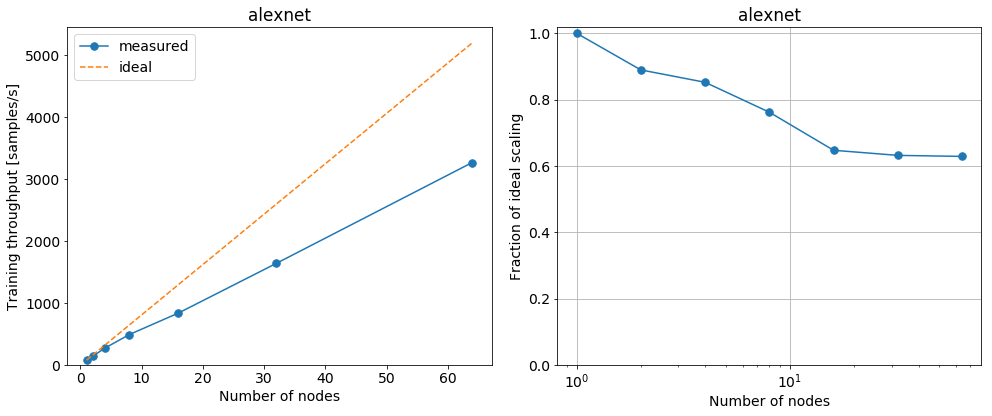

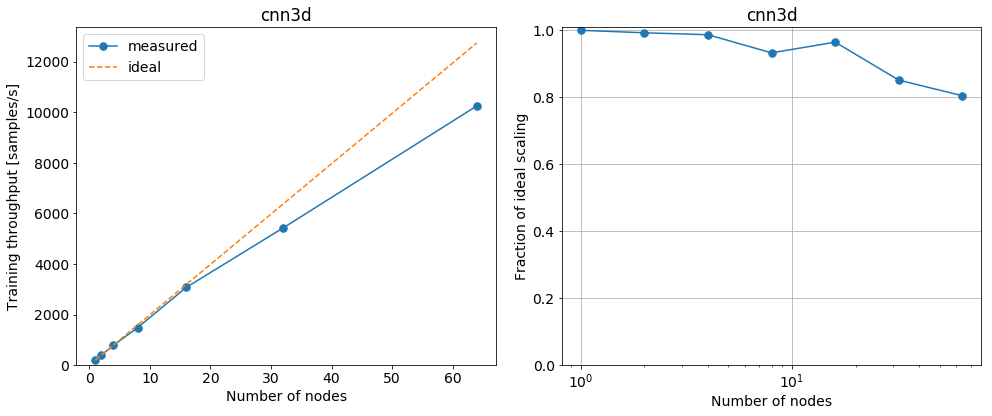

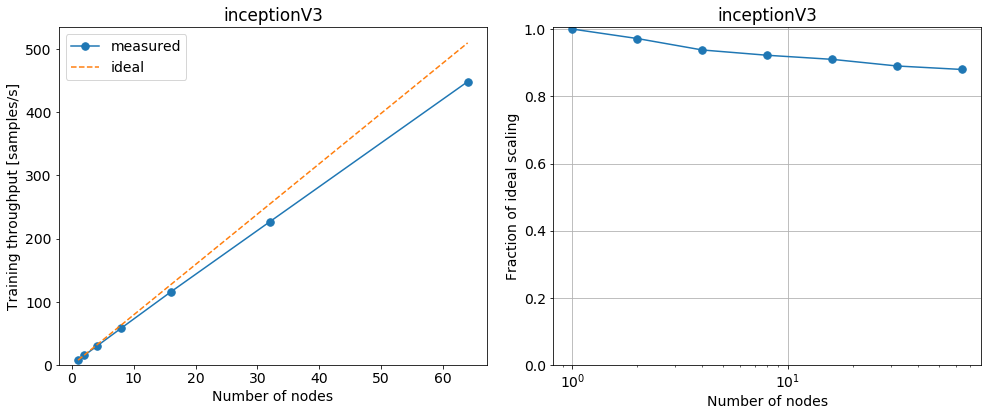

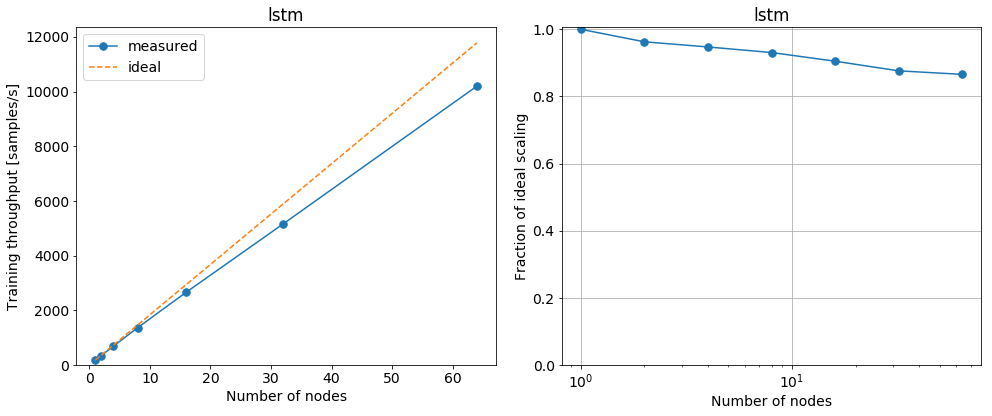

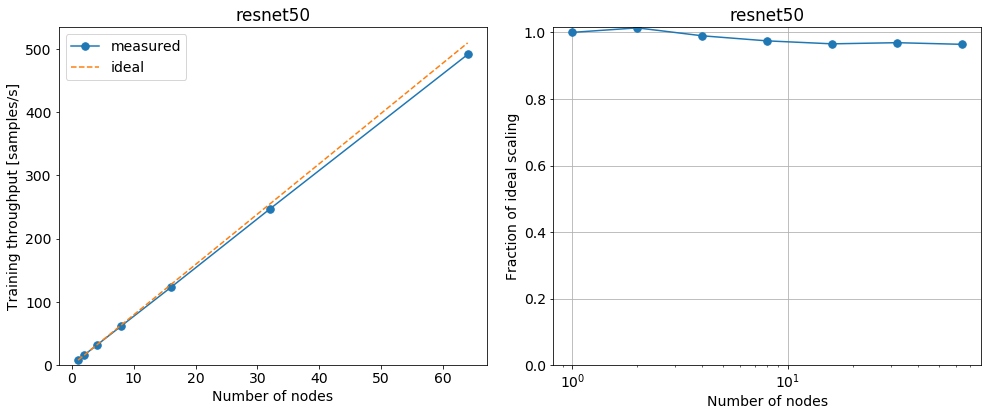

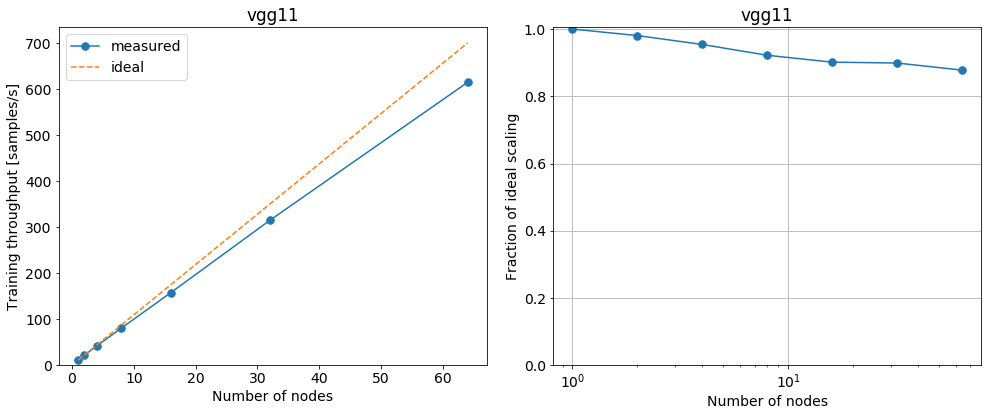

In [12]:
for model in models:
    model_results = results.groupby('model').get_group(model)
    fig, ax0, ax1 = plot_scaling(model_results.ranks.values, model_results.rate.values, title=model)